In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(1797, 64)


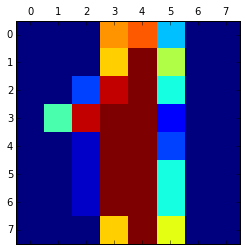

(1797, 15)
best bandwidth: 3.79269019073
KernelDensity(algorithm='auto', atol=0, bandwidth=3.7926901907322499,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)


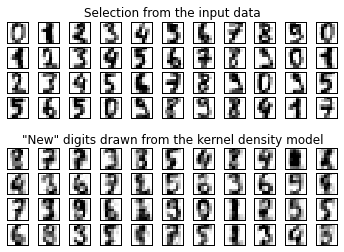

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
data = digits.images[1]
plt.matshow(digits.images[1])
plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)
print(data.shape)

from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_
print(kde)
# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)
# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')
plt.show()


In [ ]:
from sklearn import svm, metrics

data = np.genfromtxt('train.csv', delimiter=',', skip_header=1)
images = data[:, 1:]
target = data[:, 0]

#images_and_labels = list(zip(images, target))
#for index, (image, label) in enumerate(images_and_labels[:4]):
#    plt.subplot(2, 4, index + 1)
#    plt.axis('off')
#    plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
#    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
#n_samples = len(images)

# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf', C=100, gamma=0.01)

# We learn the digits on the first half of the digits
train_count = len(images)/2
classifier.fit(images[:train_count], target[:train_count])

# Now predict the value of the digit on the second half:
expected = target[train_count:]
predicted = classifier.predict(images[train_count:])

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

#images_and_predictions = list(zip(images[train_count:train_count+4], predicted))
#for index, (image, prediction) in enumerate(images_and_predictions[:4]):
#    plt.subplot(2, 4, index + 5)
#    plt.axis('off')
#    plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
#    plt.title('Prediction: %i' % prediction)

#plt.show()

In [ ]:
import optunity
import optunity.metrics
import sklearn.svm

data = np.genfromtxt('tmp.csv', delimiter=',', skip_header=1)
images = data[:, 1:]
target = data[:, 0]

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=images, y=target, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, C, gamma):
    model = sklearn.svm.SVC(kernel='linear', C=C, gamma=gamma).fit(x_train, y_train)
    decision_values = model.predict(x_test)
    print(C, gamma, optunity.metrics.error_rate(y_test, decision_values))
    return optunity.metrics.error_rate(y_test, decision_values)

# perform tuning
optimal_pars, _, _ = optunity.minimize(svm_auc, num_evals=50, C=[0, 3], gamma=[0, 0.0000001])
print(optimal_pars)

In [ ]:
import pandas as pd 

df = pd.read_csv('train.csv')
df = df.astype(float64)
df.shape

In [ ]:
from sklearn.grid_search import GridSearchCV

# scikit-learn dimension reduction
from sklearn.decomposition import PCA
# scikit-learn dataset processing utils
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
pca = PCA(n_components=80)

X = min_max_scaler.fit_transform(df.ix[:9999,1:])
print(X)
X = pca.fit_transform(X)
print(X)
y = df.ix[:9999,0]


from sklearn.svm import SVC

tuned_parameters = [{'kernel' : ['rbf'], 'gamma': [0.1, 1e-2, 1e-3, 1e-4, 1e-8], 'C': [1, 10, 100, 1000]}, 
                    {'kernel' : ['poly'], 'degree' : [5, 9], 'C' : [1, 10]}]

svm = GridSearchCV( SVC(), tuned_parameters, cv=3, verbose=2 ).fit(X, y)
print(svm.best_estimator_)


Xt = min_max_scaler.fit_transform(df.ix[35000:,1:])
yt = df.ix[35000:,0]

yp = svm.predict(pca.transform(Xt))
print('prediction accuracy: %.4f' % (1./len(yt) * sum( yp == yt )) )